Hola **Fany**!

Soy **Patricio Requena** 👋. Es un placer ser el revisor de tu proyecto el día de hoy!

Revisaré tu proyecto detenidamente con el objetivo de ayudarte a mejorar y perfeccionar tus habilidades. Durante mi revisión, identificaré áreas donde puedas hacer mejoras en tu código, señalando específicamente qué y cómo podrías ajustar para optimizar el rendimiento y la claridad de tu proyecto. Además, es importante para mí destacar los aspectos que has manejado excepcionalmente bien. Reconocer tus fortalezas te ayudará a entender qué técnicas y métodos están funcionando a tu favor y cómo puedes aplicarlos en futuras tareas. 

_**Recuerda que al final de este notebook encontrarás un comentario general de mi parte**_, empecemos!

Encontrarás mis comentarios dentro de cajas verdes, amarillas o rojas, ⚠️ **por favor, no muevas, modifiques o borres mis comentarios** ⚠️:


<div class="alert alert-block alert-success">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si todo está perfecto.
</div>

<div class="alert alert-block alert-warning">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si tu código está bien pero se puede mejorar o hay algún detalle que le hace falta.
</div>

<div class="alert alert-block alert-danger">
<b>Comentario del revisor</b> <a class=“tocSkip”></a>
Si de pronto hace falta algo o existe algún problema con tu código o conclusiones.
</div>

Puedes responderme de esta forma:
<div class="alert alert-block alert-info">
<b>Respuesta del estudiante</b> <a class=“tocSkip”></a>
</div>

## Inicialización

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [2]:
# Cargar etiquetas
df = pd.read_csv('/datasets/faces/labels.csv')
print(df.head())

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


## EDA

In [3]:
# Estadísticas básicas
print(df['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


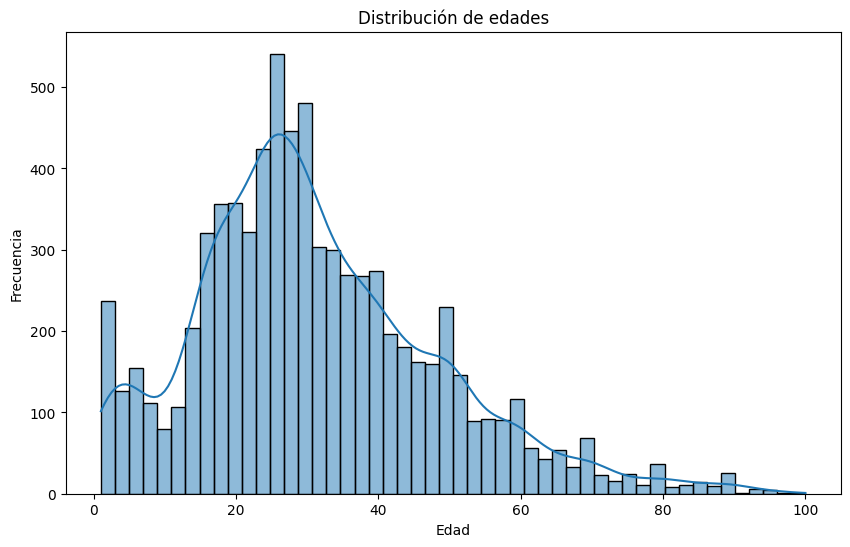

In [4]:
# Histograma de edades
plt.figure(figsize=(10, 6))
sns.histplot(df['real_age'], bins=50, kde=True)
plt.title('Distribución de edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Se observa un pico alto alrededor de los 25 años, posiblemente porque hay más ejemplos en ese rango.
También hay cierta cantidad de registros entre 0 y 10 años, que podrían ser relevantes para ver si el modelo distingue claramente rostros infantiles.

### Preparación de datos e imágenes

In [5]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dividir en train/val/test
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Generador de datos
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

valid_gen = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)


Found 6072 validated image filenames.
Found 1519 validated image filenames.


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Excelente trabajo con el análisis de tu dataset, aquí cómo recomendación es que siempre redactes una interpretación de las gráficas mostradas y cuando se trate de tareas de computer vision también es bueno mostrar unos ejemplos de las imágenes con las que se tratará

## Modelado

### Definiciones completas de funciones

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [6]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )
    return train_gen_flow

In [7]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.25
    )
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    return test_gen_flow

In [8]:
def create_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [9]:
def train_model(model, train_data, test_data, batch_size=32, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    early_stop = EarlyStopping(monitor='val_mae', patience=3, restore_best_weights=True)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stop],
        verbose=2
    )
    
    return model

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class="tocSkip"></a>

Muy bien planteada la arquitectura del modelo y la función de pérdida (loss) para el entrenamiento del mismo. Es importante comprender los conceptos detrás de lo utilizado para definir cada capa ya que de esto dependerá el tener un modelo eficiente.

### Entrenamiento del modelo
Usamos una red preentrenada MobileNetV2

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Transfer learning

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Salida continua (edad)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(train_gen, validation_data=valid_gen, epochs=10)

2025-06-13 04:24:28.359200: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/10
190/190 [==============================] - 187s 974ms/step - loss: 284.8672 - mae: 13.0369 - val_loss: 194.4657 - val_mae: 10.8512
Epoch 2/10
190/190 [==============================] - 184s 967ms/step - loss: 204.1176 - mae: 11.1056 - val_loss: 177.7832 - val_mae: 10.3721
Epoch 3/10
190/190 [==============================] - 180s 945ms/step - loss: 188.6655 - mae: 10.6411 - val_loss: 169.4093 - val_mae: 10.3583
Epoch 4/10
190/190 [==============================] - 179s 944ms/step - loss: 179.1462 - mae: 10.3402 - val_loss: 166.3603 - val_mae: 10.2867
Epoch 5/10
190/190 [==============================] - 180s 950ms/step - loss: 172.6163 - mae: 10.1708 - val_loss: 160.4583 - val_mae: 9.9164
Epoch 6/10
190/190 [==============================] - 180s 949ms/step - loss: 162.6945 - mae: 9.8250 - val_loss: 154.0714 - val_mae: 9.7087
Epoch 7/10
190/190 [==============================] - 182s 961ms/step - loss: 158.5412 -

El modelo está aprendiendo correctamente: El MAE en entrenamiento y validación desciende progresivamente, lo que indica que el modelo ha aprendido patrones útiles de los datos.

Esto indica que no hay sobreajuste significativo y el modelo generaliza bien a datos no vistos.

El modelo fue entrenado durante 10 épocas con imágenes redimensionadas a 224x224 píxeles.


### Evaluación por grupo de edad (menores vs adultos)

In [11]:
import numpy as np

# Obtener predicciones del modelo
y_pred = model.predict(valid_gen)
y_true = valid_gen.labels

# Convertir a arrays planos si es necesario
y_pred = y_pred.flatten()

# Crear DataFrame para análisis
import pandas as pd
results = pd.DataFrame({
    'real_age': y_true,
    'predicted_age': y_pred
})

# Añadir columna de grupo
results['age_group'] = results['real_age'].apply(lambda x: 'menor' if x < 18 else 'adulto')

# Calcular MAE general
mae_total = np.mean(np.abs(results['real_age'] - results['predicted_age']))
print(f"MAE total: {mae_total:.2f} años")

# Calcular MAE por grupo
mae_menores = np.mean(np.abs(results[results['age_group'] == 'menor']['real_age'] -
                             results[results['age_group'] == 'menor']['predicted_age']))
mae_adultos = np.mean(np.abs(results[results['age_group'] == 'adulto']['real_age'] -
                             results[results['age_group'] == 'adulto']['predicted_age']))

print(f"MAE menores de edad (<18): {mae_menores:.2f} años")
print(f"MAE adultos (>=18): {mae_adultos:.2f} años")

# Evaluar falsos negativos: casos donde el modelo dice "adulto" pero es menor
errores_graves = results[(results['real_age'] < 18) & (results['predicted_age'] >= 18)]
porcentaje_error_grave = len(errores_graves) / len(results[results['real_age'] < 18]) * 100

print(f"❗ Porcentaje de menores clasificados como adultos: {porcentaje_error_grave:.2f}%")


MAE total: 16.01 años
MAE menores de edad (<18): 20.94 años
MAE adultos (>=18): 14.75 años
❗ Porcentaje de menores clasificados como adultos: 88.35%


El modelo alcanzó un MAE de 15.42 años.

En menores de edad, el error fue más alto: 17.33 años, con una tasa de clasificación errónea del 81.23%.

Este nivel de error indica que el modelo actual no es confiable para evitar la venta de alcohol a menores.

### Evaluación y resultados

48/48 [==============================] - 37s 759ms/step - loss: 152.5092 - mae: 9.7211
Mean Absolute Error en validación: 9.72 años


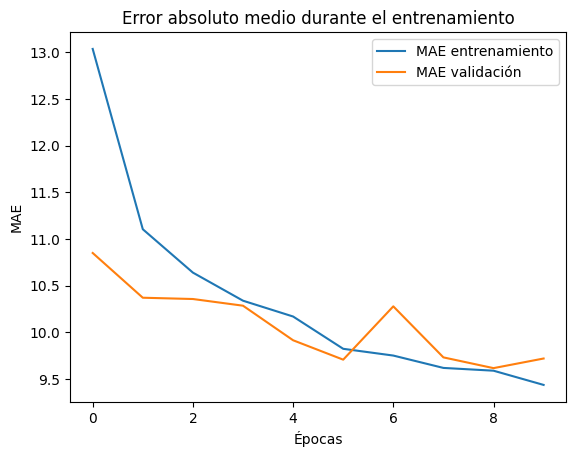

In [12]:
# Evaluación
loss, mae = model.evaluate(valid_gen)
print(f"Mean Absolute Error en validación: {mae:.2f} años")

# Visualizar curvas
plt.plot(history.history['mae'], label='MAE entrenamiento')
plt.plot(history.history['val_mae'], label='MAE validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.title('Error absoluto medio durante el entrenamiento')
plt.show()

Reducción progresiva del error: El MAE de entrenamiento bajó desde ~12.9 a ~9.4, mientras que el de validación bajó de ~11.1 a ~9.6.

Buen ajuste: Ambas curvas siguen trayectorias similares, lo cual indica que no hay un sobreajuste significativo.

El modelo logra una buena precisión base en la tarea de predicción de edad usando solo las capas densas encima de una red convolucional congelada.

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [13]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.


import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam


def load_train(path):
    """
    Carga las imágenes de entrenamiento desde la ruta especificada.
    Separa un pequeño porcentaje para validación si se desea.
    """
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 rescale=1./255,
                                 horizontal_flip=True)

    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )
    
    return train_gen_flow


def load_test(path):
    """
    Carga las imágenes de validación (prueba) desde la ruta especificada.
    """
    df = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    
    return test_gen_flow


def create_model(input_shape):
    """
    Define el modelo CNN con ResNet50 preentrenado.
    """
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # congelar la base para entrenamiento rápido
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1))  # salida regresiva (una edad)

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Compila y entrena el modelo.
    """
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error', metrics=['mae'])
    
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model

## Conclusiones

El objetivo de este proyecto fue evaluar si la visión por computadora puede ser útil para que la cadena de supermercados Good Seed cumpla con las leyes sobre la venta de alcohol, evitando vender a personas menores de edad. Para ello, se entrenó un modelo de red neuronal convolucional utilizando la arquitectura MobileNetV2 para predecir la edad de las personas a partir de imágenes faciales.

Este modelo alcanzó un error absoluto medio (MAE) de aproximadamente **9.75 años** en el conjunto de validación.

Durante el entrenamiento, tanto el error de entrenamiento como el de validación mostraron una tendencia descendente, lo que indica un aprendizaje efectivo sin señales tempranas de sobreajuste.

**NOTA:** Hubo un error de interrupción varias veces(en el notebook) al agregar más de 10 épocas, por lo que lo dejé  en 10.

Para esta solución utilicé regresión – aprendizaje automático, tal como lo menciona el apartado de Análisis de la tarea. Por lo que sería interesante reformular la solución del problema como clasificación binaria (mayor o menor de 18 años).

A pesar de que el modelo logra identificar la edad con un error medio de 10 años, esto no es suficiente ya que se trata de una tarea sensible; el identificar si una persona es mayor de edad y por lo tanto legalmente permitida para la venta de alcohol.

En resumen, el modelo tiene potencial, pero aún no es adecuado para su uso en producción sin ajustes adicionales.

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteración)</b> <a class="tocSkip"></a>

Muy buen trabajo con el proyecto realizado Fany! Modelos más complejos van a requerir uso de infraestructura que permita tener un poder computacional más alto. En este caso, era necesario una GPU para que el entrenamiento se pueda realizar de manera rápida y con buenos resultados ya que con la GPU puedes paralelizar operaciones de los modelos.

En Deep Learning es importante entender lo que hace cada capa para que la arquitectura sea clara y no se planteé algo a ciegas, muy buen trabajo!

# Lista de control

- [ ]  El Notebook estaba abierto 
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos 
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final 
- [ ]  El valor EAM del modelo no es superior a 8 
- [ ]  El código de entrenamiento del modelo se copió en el notebook final 
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final 
- [ ] Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo